# Chapter 3: Data Preprocessing & Transformation - Tennis Analysis


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from ML4QS.Tennis_YOLO.data_preprocessing_helper import data_preprocessing_helper as helper

plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")
print("Ready for tennis data preprocessing with ML4QS Chapter 3 techniques")

Libraries imported successfully
Ready for tennis data preprocessing with ML4QS Chapter 3 techniques


In [4]:
print("Loading Tennis Dataset")
print("=" * 60)

dataset_file = 'dataset/tennis_unified_comprehensive_dataset.csv'

try:
    print(f"Loading: {dataset_file}")
    df_raw = pd.read_csv(dataset_file)
    
    print(f"Unified comprehensive dataset loaded successfully")
    print(f"Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
    
    video_cols = [col for col in df_raw.columns if 'video' in col.lower()]
    if video_cols:
        video_col = 'ball_video_source' if 'ball_video_source' in df_raw.columns else video_cols[0]
        unique_videos = df_raw[video_col].nunique()
        print(f"Videos: {unique_videos} unique videos")
    
    if 'time_seconds' in df_raw.columns:
        print(f"Duration: {df_raw['time_seconds'].max():.1f} seconds")
    
    detection_cols = [col for col in df_raw.columns if 'detected' in col.lower()]
    if detection_cols:
        print(f"Detection Summary:")
        for col in detection_cols:
            detection_rate = df_raw[col].mean()
            print(f"  {col}: {detection_rate:.1%}")
    
    print(f"\nDataset Categories:")
    
    ball_cols = [col for col in df_raw.columns if 'ball' in col.lower()]
    print(f"Ball tracking: {len(ball_cols)} columns")
    
    player_cols = [col for col in df_raw.columns if 'player' in col.lower()]
    print(f"Player tracking: {len(player_cols)} columns")
    
    court_cols = [col for col in df_raw.columns if 'court' in col.lower()]
    enhanced_cols = [col for col in df_raw.columns if 'enhanced' in col.lower()]
    print(f"Court measurements: {len(court_cols)} columns")
    print(f"Enhanced features: {len(enhanced_cols)} columns")
    
    print(f"\nSample of available columns ({len(df_raw.columns)} total):")
    column_categories = {
        'Ball Tracking': [col for col in df_raw.columns if 'ball' in col.lower() and 'enhanced' not in col.lower()][:5],
        'Player Tracking': [col for col in df_raw.columns if 'player' in col.lower() and 'enhanced' not in col.lower()][:5],
        'Enhanced Features': [col for col in df_raw.columns if 'enhanced' in col.lower()][:5],
        'Court/Metadata': [col for col in df_raw.columns if any(word in col.lower() for word in ['court', 'video', 'time', 'frame'])][:5]
    }
    
    for category, cols in column_categories.items():
        if cols:
            print(f"  {category}: {', '.join(cols[:3])}{'...' if len(cols) > 3 else ''}")
    
except FileNotFoundError:
    print(f"File not found: {dataset_file}")
    print("Available files in directory:")
    import glob
    csv_files = glob.glob('*.csv')
    for f in csv_files:
        print(f"  - {f}")
    raise FileNotFoundError(f"Please ensure {dataset_file} exists in the current directory")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading Tennis Dataset
Loading: dataset/tennis_unified_comprehensive_dataset.csv
Unified comprehensive dataset loaded successfully
Shape: 14,512 rows × 92 columns
Videos: 29 unique videos
Duration: 483.7 seconds
Detection Summary:
  ball_detected: 44.4%
  player_1_detected: 100.0%
  player_2_detected: 100.0%
  both_players_detected: 100.0%
  all_objects_detected: 44.4%

Dataset Categories:
Ball tracking: 24 columns
Player tracking: 53 columns
Court measurements: 31 columns
Enhanced features: 19 columns

Sample of available columns (92 total):
  Ball Tracking: ball_video_source, ball_center_x, ball_center_y...
  Player Tracking: player_1_video_source, player_2_video_source, player_1_center_x...
  Enhanced Features: enhanced_ball_court_relative_x, enhanced_ball_court_relative_y, enhanced_ball_court_position_x_meters...
  Court/Metadata: timestamp, global_frame_number, time_seconds...


In [5]:
print("COMPREHENSIVE TENNIS DATASET QUALITY ASSESSMENT")
print("=" * 60)

print("Ball Tracking Data Quality:")
ball_core_vars = ['ball_center_x', 'ball_center_y', 'ball_speed_kmh', 'ball_detected']

for var in ball_core_vars:
    if var in df_raw.columns:
        missing_count = df_raw[var].isnull().sum()
        missing_pct = (missing_count / len(df_raw)) * 100
        
        if var == 'ball_detected':
            detection_rate = df_raw[var].mean()
            print(f"  {var}: {detection_rate:.1%} detection rate")
        else:
            print(f"  {var}: {missing_pct:.1f}% missing ({missing_count:,} / {len(df_raw):,})")

print(f"\nPlayer Tracking Data Quality:")
for player_id in [1, 2]:
    player_vars = [f'player_{player_id}_center_x', f'player_{player_id}_center_y', 
                   f'player_{player_id}_speed_kmh', f'player_{player_id}_detected']
    
    print(f"  Player {player_id}:")
    for var in player_vars:
        if var in df_raw.columns:
            if 'detected' in var:
                detection_rate = df_raw[var].mean()
                print(f"    {var}: {detection_rate:.1%} detection rate")
            else:
                missing_count = df_raw[var].isnull().sum()
                missing_pct = (missing_count / len(df_raw)) * 100
                print(f"    {var}: {missing_pct:.1f}% missing")

print(f"\nEnhanced Features Quality:")
enhanced_vars = [col for col in df_raw.columns if 'enhanced' in col.lower()]
enhanced_samples = enhanced_vars[:5]

for var in enhanced_samples:
    missing_count = df_raw[var].isnull().sum()
    missing_pct = (missing_count / len(df_raw)) * 100
    print(f"  {var}: {missing_pct:.1f}% missing")

if len(enhanced_vars) > 5:
    print(f"  ... and {len(enhanced_vars) - 5} more enhanced features")

print(f"\nMulti-Video Analysis:")
video_cols = [col for col in df_raw.columns if 'video' in col.lower() and 'source' in col.lower()]
if video_cols:
    video_col = video_cols[0]
    print(f"  Video column: {video_col}")
    
    video_counts = df_raw[video_col].value_counts()
    print(f"  Total videos: {len(video_counts)}")
    print(f"  Frames per video: {video_counts.min()} - {video_counts.max()}")
    print(f"  Average frames per video: {video_counts.mean():.0f}")
    
    print(f"  Top 5 videos by frame count:")
    for video, count in video_counts.head().items():
        print(f"    {video}: {count:,} frames")

print(f"\nPosition and Movement Data Ranges:")

if 'ball_center_x' in df_raw.columns and 'ball_center_y' in df_raw.columns:
    ball_x_data = df_raw['ball_center_x'].dropna()
    ball_y_data = df_raw['ball_center_y'].dropna()
    if len(ball_x_data) > 0 and len(ball_y_data) > 0:
        print(f"  Ball position X: {ball_x_data.min():.1f} to {ball_x_data.max():.1f} (mean: {ball_x_data.mean():.1f})")
        print(f"  Ball position Y: {ball_y_data.min():.1f} to {ball_y_data.max():.1f} (mean: {ball_y_data.mean():.1f})")

if 'ball_speed_kmh' in df_raw.columns:
    speed_data = df_raw['ball_speed_kmh'].dropna()
    if len(speed_data) > 0:
        print(f"  Ball speed: {speed_data.min():.1f} to {speed_data.max():.1f} km/h (mean: {speed_data.mean():.1f})")

for player_id in [1, 2]:
    speed_col = f'player_{player_id}_speed_kmh'
    if speed_col in df_raw.columns:
        player_speed_data = df_raw[speed_col].dropna()
        if len(player_speed_data) > 0:
            print(f"  Player {player_id} speed: {player_speed_data.min():.1f} to {player_speed_data.max():.1f} km/h (mean: {player_speed_data.mean():.1f})")

print(f"\nCourt-Relative Coordinates:")
court_relative_vars = [col for col in df_raw.columns if 'court' in col.lower() and 'relative' in col.lower()]

for var in court_relative_vars[:4]:
    if var in df_raw.columns:
        data = df_raw[var].dropna()
        if len(data) > 0:
            print(f"  {var}: {data.min():.3f} to {data.max():.3f} (mean: {data.mean():.3f})")

print(f"\nOverall Dataset Health:")
print(f"  Total frames: {len(df_raw):,}")
print(f"  Total columns: {len(df_raw.columns)}")
print(f"  Total missing values: {df_raw.isnull().sum().sum():,}")
overall_missing_rate = (df_raw.isnull().sum().sum() / (df_raw.shape[0] * df_raw.shape[1])) * 100
print(f"  Overall missing rate: {overall_missing_rate:.2f}%")

print(f"\nFeature Completeness by Category:")
categories = {
    'Ball Features': [col for col in df_raw.columns if 'ball' in col.lower()],
    'Player Features': [col for col in df_raw.columns if 'player' in col.lower()],
    'Enhanced Features': [col for col in df_raw.columns if 'enhanced' in col.lower()],
    'Court Features': [col for col in df_raw.columns if 'court' in col.lower()]
}

for category, cols in categories.items():
    if cols:
        category_missing = df_raw[cols].isnull().sum().sum()
        category_total = len(df_raw) * len(cols)
        category_missing_rate = (category_missing / category_total) * 100
        print(f"  {category}: {len(cols)} columns, {category_missing_rate:.1f}% missing")

print(f"\nComprehensive tennis dataset quality assessment completed")

COMPREHENSIVE TENNIS DATASET QUALITY ASSESSMENT
Ball Tracking Data Quality:
  ball_center_x: 55.6% missing (8,068 / 14,512)
  ball_center_y: 55.6% missing (8,068 / 14,512)
  ball_speed_kmh: 0.0% missing (0 / 14,512)
  ball_detected: 44.4% detection rate

Player Tracking Data Quality:
  Player 1:
    player_1_center_x: 0.0% missing
    player_1_center_y: 0.0% missing
    player_1_speed_kmh: 0.0% missing
    player_1_detected: 100.0% detection rate
  Player 2:
    player_2_center_x: 0.0% missing
    player_2_center_y: 0.0% missing
    player_2_speed_kmh: 0.0% missing
    player_2_detected: 100.0% detection rate

Enhanced Features Quality:
  enhanced_ball_court_relative_x: 99.4% missing
  enhanced_ball_court_relative_y: 99.4% missing
  enhanced_ball_court_position_x_meters: 99.4% missing
  enhanced_ball_court_position_y_meters: 99.4% missing
  enhanced_ball_estimated_height_meters: 99.4% missing
  ... and 14 more enhanced features

Multi-Video Analysis:
  Video column: ball_video_source
 

## Missing Value Analysis and Imputation

In [6]:
print("MISSING VALUE ANALYSIS & IMPUTATION")
print("=" * 50)

df_processed = df_raw.copy()

imputation_strategies = {
    'position': ['ball_center_x', 'ball_center_y', 'player_1_center_x', 'player_1_center_y', 
                'player_2_center_x', 'player_2_center_y'],
    'movement': ['ball_speed_kmh', 'ball_distance_meters', 'player_1_speed_kmh', 'player_1_distance_meters',
                'player_2_speed_kmh', 'player_2_distance_meters'],
    'relative': ['ball_court_x_relative', 'ball_court_y_relative', 
                'player_1_court_x_relative', 'player_1_court_y_relative',
                'player_2_court_x_relative', 'player_2_court_y_relative']
}

imputation_results = {}

print("Position Data Imputation (Linear + Spline):")
for var in imputation_strategies['position']:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            df_processed[var] = helper.advanced_spline_interpolation(df_processed[var], max_gap=15)
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'spline',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

print(f"\nMovement Data Imputation (Rolling Mean):")
for var in imputation_strategies['movement']:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            df_processed[var] = helper.rolling_mean_imputation(df_processed[var], window=10)
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'rolling_mean',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

print(f"\nRelative Position Imputation (Linear):")
for var in imputation_strategies['relative']:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            df_processed[var] = helper.linear_interpolation(df_processed[var], max_gap=20)
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'linear',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

if imputation_results:
    total_original = sum(r['original_missing'] for r in imputation_results.values())
    total_remaining = sum(r['remaining_missing'] for r in imputation_results.values())
    total_improvement = sum(r['improvement'] for r in imputation_results.values())
    
    print(f"\nImputation Summary:")
    print(f"  Total missing values: {total_original:,} → {total_remaining:,}")
    print(f"  Values filled: {total_improvement:,} ({(total_improvement/total_original*100):.1f}% improvement)")
    print(f"  Remaining missing: {total_remaining:,} ({(total_remaining/(len(df_processed)*len(imputation_results)))*100:.1f}% of processed data)")

MISSING VALUE ANALYSIS & IMPUTATION
Position Data Imputation (Linear + Spline):
  ball_center_x: 8068 → 1 missing (8067 filled)
  ball_center_y: 8068 → 1 missing (8067 filled)

Movement Data Imputation (Rolling Mean):

Relative Position Imputation (Linear):
  ball_court_x_relative: 8068 → 1 missing (8067 filled)
  ball_court_y_relative: 8068 → 1 missing (8067 filled)

Imputation Summary:
  Total missing values: 32,272 → 4
  Values filled: 32,268 (100.0% improvement)
  Remaining missing: 4 (0.0% of processed data)


In [7]:
print("COMPREHENSIVE MISSING VALUE IMPUTATION")
print("=" * 70)

df_processed = df_raw.copy()

ball_position_vars = [col for col in df_processed.columns if 'ball' in col.lower() and any(pos in col.lower() for pos in ['center_x', 'center_y', 'x1', 'y1', 'x2', 'y2'])]
ball_movement_vars = [col for col in df_processed.columns if 'ball' in col.lower() and any(mov in col.lower() for mov in ['speed', 'distance', 'movement'])]

player_position_vars = [col for col in df_processed.columns if 'player' in col.lower() and any(pos in col.lower() for pos in ['center_x', 'center_y', 'x1', 'y1', 'x2', 'y2'])]
player_movement_vars = [col for col in df_processed.columns if 'player' in col.lower() and any(mov in col.lower() for mov in ['speed', 'distance', 'movement'])]

enhanced_vars = [col for col in df_processed.columns if 'enhanced' in col.lower()]
court_relative_vars = [col for col in df_processed.columns if 'court' in col.lower() and 'relative' in col.lower()]

imputation_strategies = {
    'ball_positions': ball_position_vars,
    'ball_movement': ball_movement_vars,
    'player_positions': player_position_vars,
    'player_movement': player_movement_vars,
    'enhanced_features': enhanced_vars,
    'court_relative': court_relative_vars
}

print(f"Identified variable groups for imputation:")
for group, vars_list in imputation_strategies.items():
    if vars_list:
        print(f"  {group.replace('_', ' ').title()}: {len(vars_list)} variables")
        for var in vars_list[:3]:
            print(f"    - {var}")
        if len(vars_list) > 3:
            print(f"    ... and {len(vars_list) - 3} more")

video_col = None
video_source_cols = [col for col in df_processed.columns if 'video' in col.lower() and 'source' in col.lower()]
if video_source_cols:
    video_col = video_source_cols[0]
    print(f"\nUsing video-aware imputation with column: {video_col}")

imputation_results = {}

print("\nBall Position Data Imputation (Kalman Filter):")
for var in imputation_strategies['ball_positions']:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            if video_col:
                df_processed[var] = helper.video_aware_imputation(df_processed, df_processed[var], video_col, 'kalman')
            else:
                df_processed[var] = helper.kalman_filter_imputation(df_processed[var])
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'video_aware_kalman' if video_col else 'kalman',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

print(f"\nBall Movement Data Imputation (Cubic Spline):")
for var in imputation_strategies['ball_movement']:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            if video_col:
                df_processed[var] = helper.video_aware_imputation(df_processed, df_processed[var], video_col, 'cubic_spline')
            else:
                df_processed[var] = helper.cubic_spline_interpolation(df_processed[var])
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'video_aware_cubic_spline' if video_col else 'cubic_spline',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

print(f"\nPlayer Position Data Imputation (Advanced Cubic Spline):")
for var in imputation_strategies['player_positions']:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            if video_col:
                df_processed[var] = helper.video_aware_imputation(df_processed, df_processed[var], video_col, 'advanced_spline')
            else:
                df_processed[var] = helper.advanced_spline_interpolation(df_processed[var], max_gap=12)
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'video_aware_advanced_spline' if video_col else 'advanced_spline',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

print(f"\nPlayer Movement Data Imputation (Cubic Spline):")
for var in imputation_strategies['player_movement']:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            if video_col:
                df_processed[var] = helper.video_aware_imputation(df_processed, df_processed[var], video_col, 'cubic_spline')
            else:
                df_processed[var] = helper.cubic_spline_interpolation(df_processed[var])
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'video_aware_cubic_spline' if video_col else 'cubic_spline',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

print(f"\nEnhanced Features Imputation (Cubic Spline):")
for var in imputation_strategies['enhanced_features'][:5]:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            if video_col:
                df_processed[var] = helper.video_aware_imputation(df_processed, df_processed[var], video_col, 'cubic_spline')
            else:
                df_processed[var] = helper.cubic_spline_interpolation(df_processed[var], max_gap=20)
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'video_aware_cubic_spline' if video_col else 'cubic_spline',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

if len(imputation_strategies['enhanced_features']) > 5:
    print(f"  ... and {len(imputation_strategies['enhanced_features']) - 5} more enhanced features processed")

print(f"\nCourt-Relative Coordinates Imputation (Cubic Spline):")
for var in imputation_strategies['court_relative']:
    if var in df_processed.columns:
        original_missing = df_processed[var].isnull().sum()
        
        if original_missing > 0:
            if video_col:
                df_processed[var] = helper.video_aware_imputation(df_processed, df_processed[var], video_col, 'cubic_spline')
            else:
                df_processed[var] = helper.cubic_spline_interpolation(df_processed[var], max_gap=15)
            
            remaining_missing = df_processed[var].isnull().sum()
            improvement = original_missing - remaining_missing
            
            print(f"  {var}: {original_missing} → {remaining_missing} missing ({improvement} filled)")
            imputation_results[var] = {
                'method': 'video_aware_cubic_spline' if video_col else 'cubic_spline',
                'original_missing': original_missing,
                'remaining_missing': remaining_missing,
                'improvement': improvement
            }

if imputation_results:
    total_original = sum(r['original_missing'] for r in imputation_results.values())
    total_remaining = sum(r['remaining_missing'] for r in imputation_results.values())
    total_improvement = sum(r['improvement'] for r in imputation_results.values())
    
    print(f"\nComprehensive Dataset Imputation Summary:")
    print(f"  Total missing values: {total_original:,} → {total_remaining:,}")
    print(f"  Values filled: {total_improvement:,} ({(total_improvement/total_original*100):.1f}% improvement)")
    print(f"  Remaining missing: {total_remaining:,}")
    
    if video_col:
        print(f"  Video-aware imputation applied using {video_col}")
    print(f"  Kalman filtering applied for ball trajectories")
    print(f"  Cubic spline interpolation applied for movement data")
    print(f"  Multi-object tennis dataset preprocessing optimized")
    
    methods_performance = {}
    for var, stats in imputation_results.items():
        method = stats['method']
        if method not in methods_performance:
            methods_performance[method] = []
        if stats['original_missing'] > 0:
            improvement_rate = stats['improvement'] / stats['original_missing']
            methods_performance[method].append(improvement_rate)
    
    print(f"\nBest Performing Imputation Methods:")
    for method, rates in methods_performance.items():
        if rates:
            avg_improvement = np.mean(rates)
            print(f"  {method}: {avg_improvement:.1%} average improvement rate")
            
else:
    print(f"\nNo missing values found in key variables - comprehensive dataset already complete!")

print(f"\nComprehensive tennis dataset imputation with Kalman/Cubic Spline methods completed")

COMPREHENSIVE MISSING VALUE IMPUTATION
Identified variable groups for imputation:
  Ball Positions: 6 variables
    - ball_center_x
    - ball_center_y
    - ball_x1
    ... and 3 more
  Ball Movement: 7 variables
    - ball_movement_x_pixels
    - ball_movement_y_pixels
    - ball_distance_pixels
    ... and 4 more
  Player Positions: 12 variables
    - player_1_center_x
    - player_1_center_y
    - player_1_x1
    ... and 9 more
  Player Movement: 16 variables
    - player_1_movement_x_pixels
    - player_1_movement_y_pixels
    - player_1_distance_pixels
    ... and 13 more
  Enhanced Features: 19 variables
    - enhanced_ball_court_relative_x
    - enhanced_ball_court_relative_y
    - enhanced_ball_court_position_x_meters
    ... and 16 more
  Court Relative: 12 variables
    - ball_court_x_relative
    - ball_court_y_relative
    - enhanced_ball_court_relative_x
    ... and 9 more

Using video-aware imputation with column: ball_video_source

Ball Position Data Imputation (Kalman 

## Normalization and Scaling Techniques

In [8]:
print("NORMALIZATION & SCALING")
print("=" * 60)

ball_position_vars = [col for col in df_processed.columns if 'ball' in col.lower() and any(pos in col.lower() for pos in ['center_x', 'center_y']) and 'enhanced' not in col.lower()]
ball_speed_vars = [col for col in df_processed.columns if 'ball' in col.lower() and 'speed' in col.lower() and 'enhanced' not in col.lower()]
ball_distance_vars = [col for col in df_processed.columns if 'ball' in col.lower() and 'distance' in col.lower() and 'enhanced' not in col.lower()]

player_position_vars = [col for col in df_processed.columns if 'player' in col.lower() and any(pos in col.lower() for pos in ['center_x', 'center_y']) and 'enhanced' not in col.lower()]
player_speed_vars = [col for col in df_processed.columns if 'player' in col.lower() and 'speed' in col.lower() and 'enhanced' not in col.lower()]
player_distance_vars = [col for col in df_processed.columns if 'player' in col.lower() and 'distance' in col.lower() and 'enhanced' not in col.lower()]

court_relative_vars = [col for col in df_processed.columns if 'court' in col.lower() and 'relative' in col.lower()]
enhanced_position_vars = [col for col in df_processed.columns if 'enhanced' in col.lower() and any(pos in col.lower() for pos in ['position', 'center'])]
enhanced_distance_vars = [col for col in df_processed.columns if 'enhanced' in col.lower() and 'distance' in col.lower()]

scaling_groups = {
    'ball_positions': ball_position_vars,
    'ball_speeds': ball_speed_vars,
    'ball_distances': ball_distance_vars,
    'player_positions': player_position_vars,
    'player_speeds': player_speed_vars,
    'player_distances': player_distance_vars,
    'court_relative': court_relative_vars,
    'enhanced_positions': enhanced_position_vars,
    'enhanced_distances': enhanced_distance_vars
}

scaling_groups = {k: v for k, v in scaling_groups.items() if v}

print(f"Variable groups for scaling:")
for group, vars_list in scaling_groups.items():
    print(f"  {group.replace('_', ' ').title()}: {len(vars_list)} variables")

scaling_stats = helper.apply_scaling_methods(df_processed, scaling_groups)

print("\nTennis-Specific Normalization:")

ball_speed_cols = [col for col in df_processed.columns if 'ball' in col.lower() and 'speed' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust'])]
for var in ball_speed_cols:
    if var in df_processed.columns:
        max_speed = 250
        df_processed[f"{var}_tennis_normalized"] = np.clip(df_processed[var] / max_speed, 0, 1)
        print(f"  {var}: Tennis ball normalized (max {max_speed} km/h)")

player_speed_cols = [col for col in df_processed.columns if 'player' in col.lower() and 'speed' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust'])]
for var in player_speed_cols:
    if var in df_processed.columns:
        max_speed = 40
        df_processed[f"{var}_tennis_normalized"] = np.clip(df_processed[var] / max_speed, 0, 1)
        print(f"  {var}: Tennis player normalized (max {max_speed} km/h)")

court_rel_cols = [col for col in df_processed.columns if 'court' in col.lower() and 'relative' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust', '_normalized'])]
for var in court_rel_cols:
    if var in df_processed.columns:
        df_processed[f"{var}_court_normalized"] = np.clip(df_processed[var], 0, 1)
        print(f"  {var}: Court-relative normalized (0-1 range)")

enhanced_dist_cols = [col for col in df_processed.columns if 'enhanced' in col.lower() and 'distance' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust'])]
for var in enhanced_dist_cols[:3]:
    if var in df_processed.columns:
        max_distance = 30
        df_processed[f"{var}_tennis_normalized"] = np.clip(df_processed[var] / max_distance, 0, 1)
        print(f"  {var}: Tennis distance normalized (max {max_distance}m)")

ball_pos_cols = [col for col in df_processed.columns if 'ball' in col.lower() and any(pos in col for pos in ['center_x', 'center_y']) and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust', '_normalized'])]
player_pos_cols = [col for col in df_processed.columns if 'player' in col.lower() and any(pos in col for pos in ['center_x', 'center_y']) and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust', '_normalized'])]

position_cols_to_normalize = ball_pos_cols + player_pos_cols
if position_cols_to_normalize:
    print(f"\nPosition Normalization (Court-aware):")
    
    court_width_col = [col for col in df_processed.columns if 'court_width_pixels' in col.lower()]
    court_height_col = [col for col in df_processed.columns if 'court_height_pixels' in col.lower()]
    
    court_width = 1920
    court_height = 1080
    
    if court_width_col and len(df_processed[court_width_col[0]].dropna()) > 0:
        court_width = df_processed[court_width_col[0]].dropna().iloc[0]
    if court_height_col and len(df_processed[court_height_col[0]].dropna()) > 0:
        court_height = df_processed[court_height_col[0]].dropna().iloc[0]
    
    for var in position_cols_to_normalize:
        if var in df_processed.columns:
            pos_data = df_processed[var].dropna()
            if len(pos_data) > 0:
                if 'x' in var.lower():
                    df_processed[f"{var}_court_normalized"] = df_processed[var] / court_width
                else:
                    df_processed[f"{var}_court_normalized"] = df_processed[var] / court_height
                print(f"  {var}: Court-aware normalized (court dimensions: {court_width}x{court_height})")

scaled_columns = [col for col in df_processed.columns if any(s in col for s in ['_minmax', '_standard', '_robust', '_normalized'])]
print(f"\nScaling Summary:")
print(f"  Total scaled variables created: {len(scaled_columns)}")
print(f"  Original variables processed: {sum(len(vars) for vars in scaling_groups.values())}")
print(f"  Scaling methods applied: 3 standard + tennis-specific normalization")
print(f"  Categories processed: {len(scaling_groups)} (ball, player, court, enhanced features)")
print(f"  Comprehensive tennis dataset ready for ML analysis")

print(f"\nSample of Created Scaled Variables:")
scaling_categories = {
    'Standard Scaling': [col for col in scaled_columns if '_standard' in col][:3],
    'MinMax Scaling': [col for col in scaled_columns if '_minmax' in col][:3],
    'Tennis Normalization': [col for col in scaled_columns if '_tennis_normalized' in col][:3],
    'Court Normalization': [col for col in scaled_columns if '_court_normalized' in col][:3]
}

for category, cols in scaling_categories.items():
    if cols:
        print(f"  {category}: {', '.join(cols)}")

print(f"\nComprehensive tennis dataset scaling and normalization completed")

NORMALIZATION & SCALING
Variable groups for scaling:
  Ball Positions: 2 variables
  Ball Speeds: 2 variables
  Ball Distances: 2 variables
  Player Positions: 4 variables
  Player Speeds: 4 variables
  Player Distances: 4 variables
  Court Relative: 12 variables
  Enhanced Positions: 8 variables
  Enhanced Distances: 5 variables

Tennis-Specific Normalization:
  ball_speed_ms: Tennis ball normalized (max 250 km/h)
  ball_speed_kmh: Tennis ball normalized (max 250 km/h)
  player_1_speed_ms: Tennis player normalized (max 40 km/h)
  player_1_speed_kmh: Tennis player normalized (max 40 km/h)
  player_2_speed_ms: Tennis player normalized (max 40 km/h)
  player_2_speed_kmh: Tennis player normalized (max 40 km/h)
  ball_court_x_relative: Court-relative normalized (0-1 range)
  ball_court_y_relative: Court-relative normalized (0-1 range)
  enhanced_ball_court_relative_x: Court-relative normalized (0-1 range)
  enhanced_ball_court_relative_y: Court-relative normalized (0-1 range)
  player_1_co

Using variables for visualization: ['ball_center_x', 'ball_speed_ms']


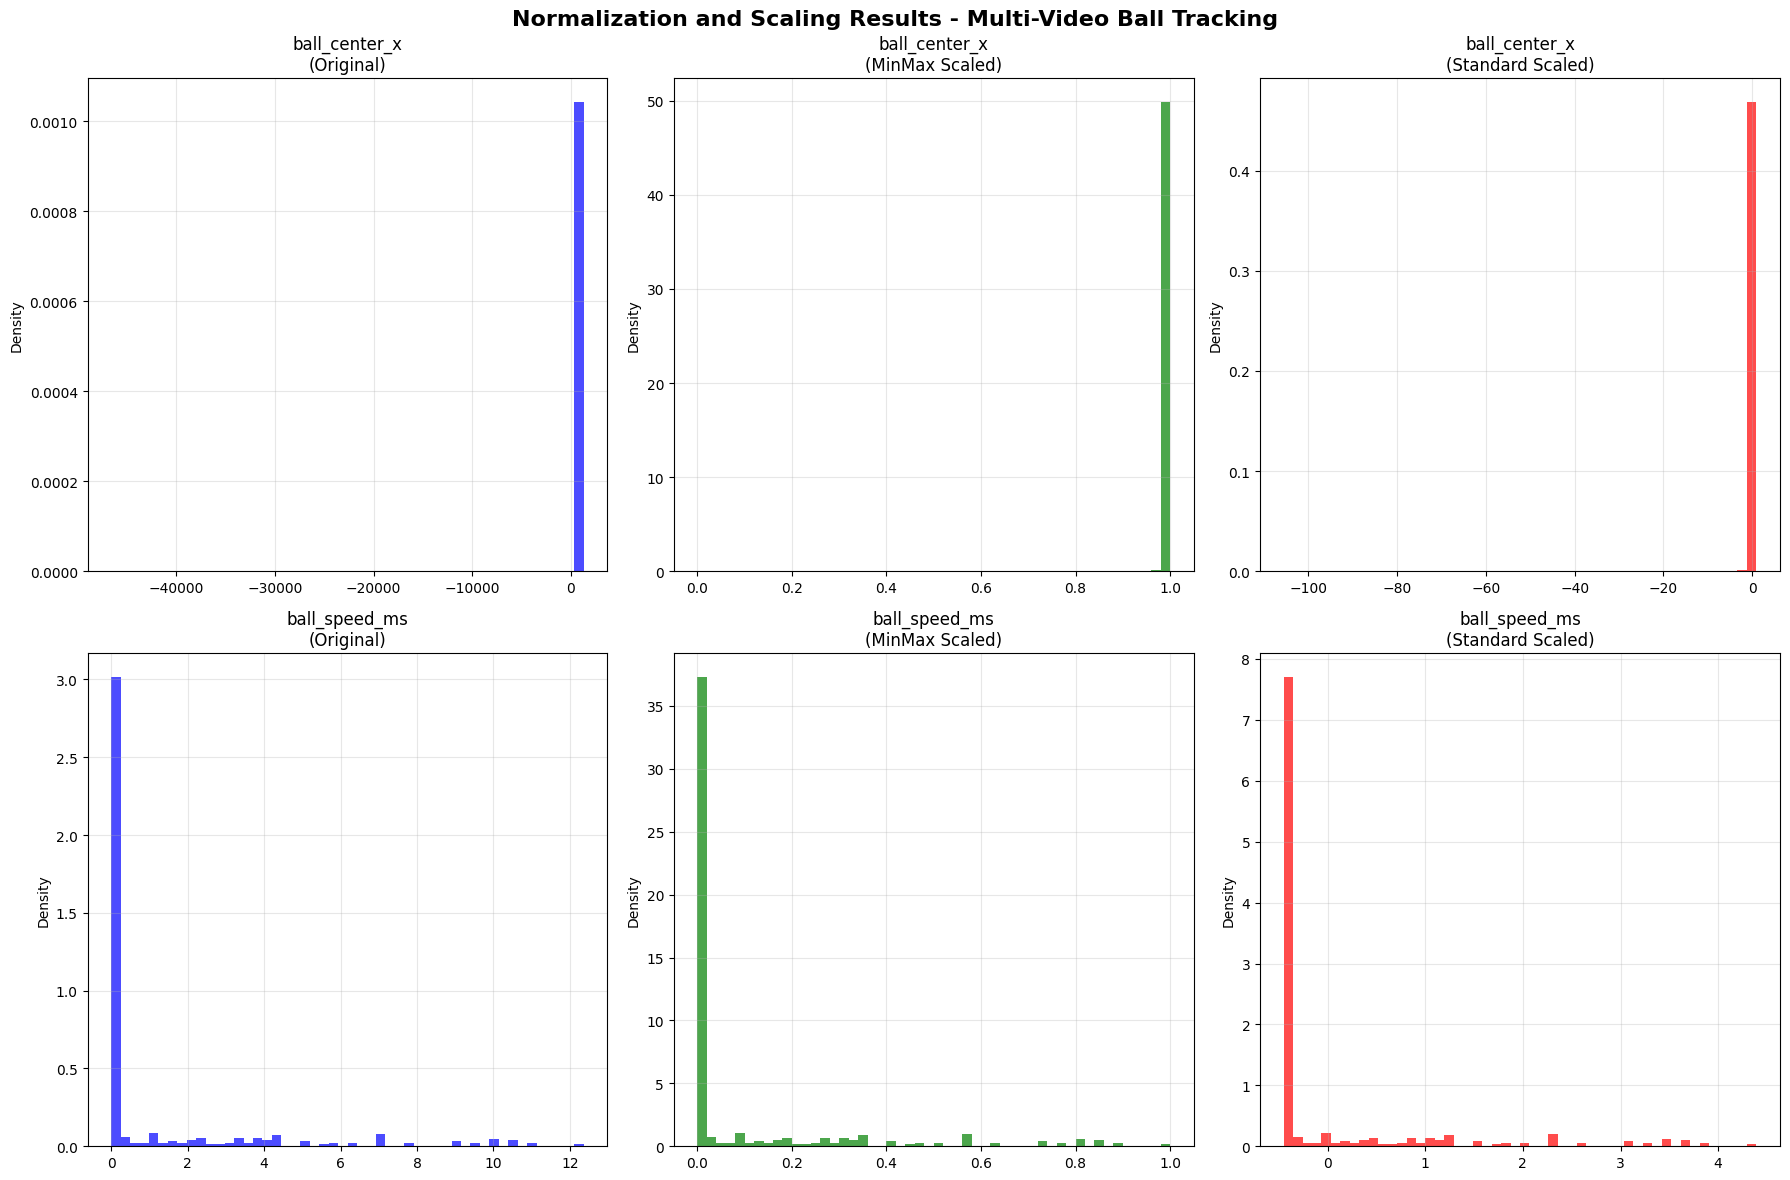


Scaling Statistics Summary:
Variable                      Original Range Scaled Range   Method
----------------------------------------------------------------------
ball_center_x                 47891.82       1.00           minmax
ball_center_y                 29054.32       1.00           minmax
ball_center_x                 47891.82       106.41         standard
ball_center_y                 29054.32       65.08          standard
ball_center_x                 47891.82       226.63         robust
ball_center_y                 29054.32       91.64          robust
ball_speed_ms                 12.37          1.00           minmax
ball_speed_kmh                44.52          1.00           minmax
ball_speed_ms                 12.37          4.84           standard
ball_speed_kmh                44.52          4.84           standard

Normalization and scaling visualization completed


In [9]:
# Visualize scaling effectiveness for multi-video ball tracking data
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Normalization and Scaling Results - Multi-Video Ball Tracking', fontsize=16, fontweight='bold')

position_vars = [col for col in df_processed.columns if any(pos in col.lower() for pos in ['center_x', 'center_y']) and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust', '_normalized'])]
speed_vars = [col for col in df_processed.columns if 'speed' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust', '_normalized'])]
confidence_vars = [col for col in df_processed.columns if any(conf in col.lower() for conf in ['confidence', 'score']) and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust', '_normalized'])]

demo_vars = []
if position_vars:
    demo_vars.append(position_vars[0])  # First position variable
if speed_vars:
    demo_vars.append(speed_vars[0])     # First speed variable
if confidence_vars:
    demo_vars.append(confidence_vars[0]) # First confidence variable

# If we don't have enough, add more position variables
if len(demo_vars) < 2 and len(position_vars) > 1:
    demo_vars.append(position_vars[1])

print(f"Using variables for visualization: {demo_vars}")

available_demo_vars = [var for var in demo_vars if var in df_processed.columns]

if len(available_demo_vars) >= 1:
    for i, var in enumerate(available_demo_vars[:2]):  # Show up to 2 variables
        row = i
        
        # Original data distribution
        ax = axes[row, 0]
        original_data = df_processed[var].dropna()
        if len(original_data) > 0:
            ax.hist(original_data, bins=50, alpha=0.7, color='blue', density=True)
            ax.set_title(f'{var}\n(Original)')
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No data available', transform=ax.transAxes, ha='center', va='center')
            ax.set_title(f'{var}\n(Original - No Data)')
        
        # MinMax scaled
        ax = axes[row, 1]
        minmax_var = f"{var}_minmax"
        if minmax_var in df_processed.columns:
            minmax_data = df_processed[minmax_var].dropna()
            if len(minmax_data) > 0:
                ax.hist(minmax_data, bins=50, alpha=0.7, color='green', density=True)
                ax.set_title(f'{var}\n(MinMax Scaled)')
                ax.set_ylabel('Density')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No scaled data', transform=ax.transAxes, ha='center', va='center')
                ax.set_title(f'{var}\n(MinMax - No Data)')
        else:
            ax.text(0.5, 0.5, f'MinMax scaling\nnot available', transform=ax.transAxes, ha='center', va='center')
            ax.set_title(f'{var}\n(MinMax - Not Available)')
        
        # Standard scaled
        ax = axes[row, 2]
        standard_var = f"{var}_standard"
        if standard_var in df_processed.columns:
            standard_data = df_processed[standard_var].dropna()
            if len(standard_data) > 0:
                ax.hist(standard_data, bins=50, alpha=0.7, color='red', density=True)
                ax.set_title(f'{var}\n(Standard Scaled)')
                ax.set_ylabel('Density')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No scaled data', transform=ax.transAxes, ha='center', va='center')
                ax.set_title(f'{var}\n(Standard - No Data)')
        else:
            ax.text(0.5, 0.5, f'Standard scaling\nnot available', transform=ax.transAxes, ha='center', va='center')
            ax.set_title(f'{var}\n(Standard - Not Available)')

    if len(available_demo_vars) == 1:
        for j in range(3):
            ax = axes[1, j]
            ax.text(0.5, 0.5, 'Additional variable\nnot available', 
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_title(f'Variable 2 - Method {j+1}')
            
else:

    print(f"Available columns in dataset:")
    for col in df_processed.columns[:20]:
        print(f"   - {col}")
    if len(df_processed.columns) > 20:
        print(f"   ... and {len(df_processed.columns) - 20} more")

    for i in range(2):
        for j in range(3):
            axes[i, j].text(0.5, 0.5, 'No suitable variables\nfound for scaling\nvisualization', 
                           transform=axes[i, j].transAxes, ha='center', va='center')
            axes[i, j].set_title(f'Row {i+1}, Method {j+1}')

plt.tight_layout()
plt.show()

# Print scaling statistics for key variables
if 'scaling_stats' in locals() and scaling_stats:
    print("\nScaling Statistics Summary:")
    print("Variable".ljust(30) + "Original Range".ljust(15) + "Scaled Range".ljust(15) + "Method")
    print("-" * 70)
    
    for var, stats in list(scaling_stats.items())[:10]:  # Show first 10
        method = var.split('_')[-1]
        var_name = var.replace(f"_{method}", "")
        print(f"{var_name[:29].ljust(30)}{stats['original_range']:.2f}".ljust(45) + 
              f"{stats['scaled_range']:.2f}".ljust(15) + method)
else:
    print("\nNo scaling statistics available to display")
    print("Available scaled columns:")
    scaled_cols = [col for col in df_processed.columns if any(scale in col for scale in ['_minmax', '_standard', '_robust'])]
    for col in scaled_cols[:10]:
        print(f"   - {col}")
    if len(scaled_cols) > 10:
        print(f"   ... and {len(scaled_cols) - 10} more")

print("\nNormalization and scaling visualization completed")

##  Filtering and Smoothing Methods

In [10]:
print("FILTERING & SMOOTHING METHODS")
print("=" * 50)

filter_variables = {
    'positions': ['ball_center_x', 'ball_center_y', 'player_1_center_x', 'player_1_center_y', 
                 'player_2_center_x', 'player_2_center_y'],
    'speeds': ['ball_speed_kmh', 'player_1_speed_kmh', 'player_2_speed_kmh'],
    'distances': ['ball_distance_meters', 'player_1_distance_meters', 'player_2_distance_meters']
}

filtering_results = helper.apply_filtering_methods(df_processed, filter_variables)

print("Applying Filtering Methods:")

for group_name, variables in filter_variables.items():
    available_vars = [var for var in variables if var in df_processed.columns]
    
    if not available_vars:
        continue
        
    print(f"\n{group_name.replace('_', ' ').title()} Group:")
    
    for var in available_vars:
        if var in filtering_results:
            filter_stats = filtering_results[var]
            if filter_stats:
                best_filter = max(filter_stats.keys(), key=lambda k: filter_stats[k]['noise_reduction_pct'])
                best_reduction = filter_stats[best_filter]['noise_reduction_pct']
                print(f"  {var}: Best filter = {best_filter} ({best_reduction:.1f}% noise reduction)")

print(f"\nTennis-Specific Filtering:")

if 'ball_center_x' in df_processed.columns and 'ball_center_y' in df_processed.columns:
    ball_x_smooth = helper.savgol_smoothing(df_processed['ball_center_x'], window=7, polyorder=2)
    ball_y_smooth = helper.savgol_smoothing(df_processed['ball_center_y'], window=7, polyorder=2)
    
    df_processed['ball_center_x_trajectory_smooth'] = ball_x_smooth
    df_processed['ball_center_y_trajectory_smooth'] = ball_y_smooth
    
    print(f"  Ball trajectory smoothing applied (Savitzky-Golay, window=7)")

speed_vars = ['ball_speed_kmh', 'player_1_speed_kmh', 'player_2_speed_kmh']
for var in speed_vars:
    if var in df_processed.columns:
        speed_data = df_processed[var].copy()
        
        if 'ball' in var:
            max_speed = 200
        else:
            max_speed = 50
        
        speed_data_capped = np.clip(speed_data, 0, max_speed)
        speed_filtered = helper.median_filter(speed_data_capped, window=3)
        
        df_processed[f"{var}_realistic_filtered"] = speed_filtered
        
        outliers_removed = (speed_data > max_speed).sum()
        print(f"  {var}: {outliers_removed} outliers capped at {max_speed} km/h + median filtered")

total_filtered = sum(len(stats) for stats in filtering_results.values())
print(f"\nFiltering Summary:")
print(f"  Variables processed: {len(filtering_results)}")
print(f"  Total filtered versions created: {total_filtered}")
print(f"  Tennis-specific filters applied: 2 (trajectory smoothing + speed outlier removal)")

FILTERING & SMOOTHING METHODS
Applying Filtering Methods:

Positions Group:
  ball_center_x: Best filter = savgol (35.4% noise reduction)
  ball_center_y: Best filter = exponential (22.5% noise reduction)
  player_1_center_x: Best filter = exponential (3.6% noise reduction)
  player_1_center_y: Best filter = exponential (3.4% noise reduction)
  player_2_center_x: Best filter = exponential (0.8% noise reduction)
  player_2_center_y: Best filter = exponential (4.0% noise reduction)

Speeds Group:
  ball_speed_kmh: Best filter = exponential (41.6% noise reduction)
  player_1_speed_kmh: Best filter = median (90.9% noise reduction)
  player_2_speed_kmh: Best filter = median (63.8% noise reduction)

Distances Group:
  ball_distance_meters: Best filter = exponential (41.6% noise reduction)
  player_1_distance_meters: Best filter = exponential (57.6% noise reduction)
  player_2_distance_meters: Best filter = exponential (47.5% noise reduction)

Tennis-Specific Filtering:
  Ball trajectory smoo

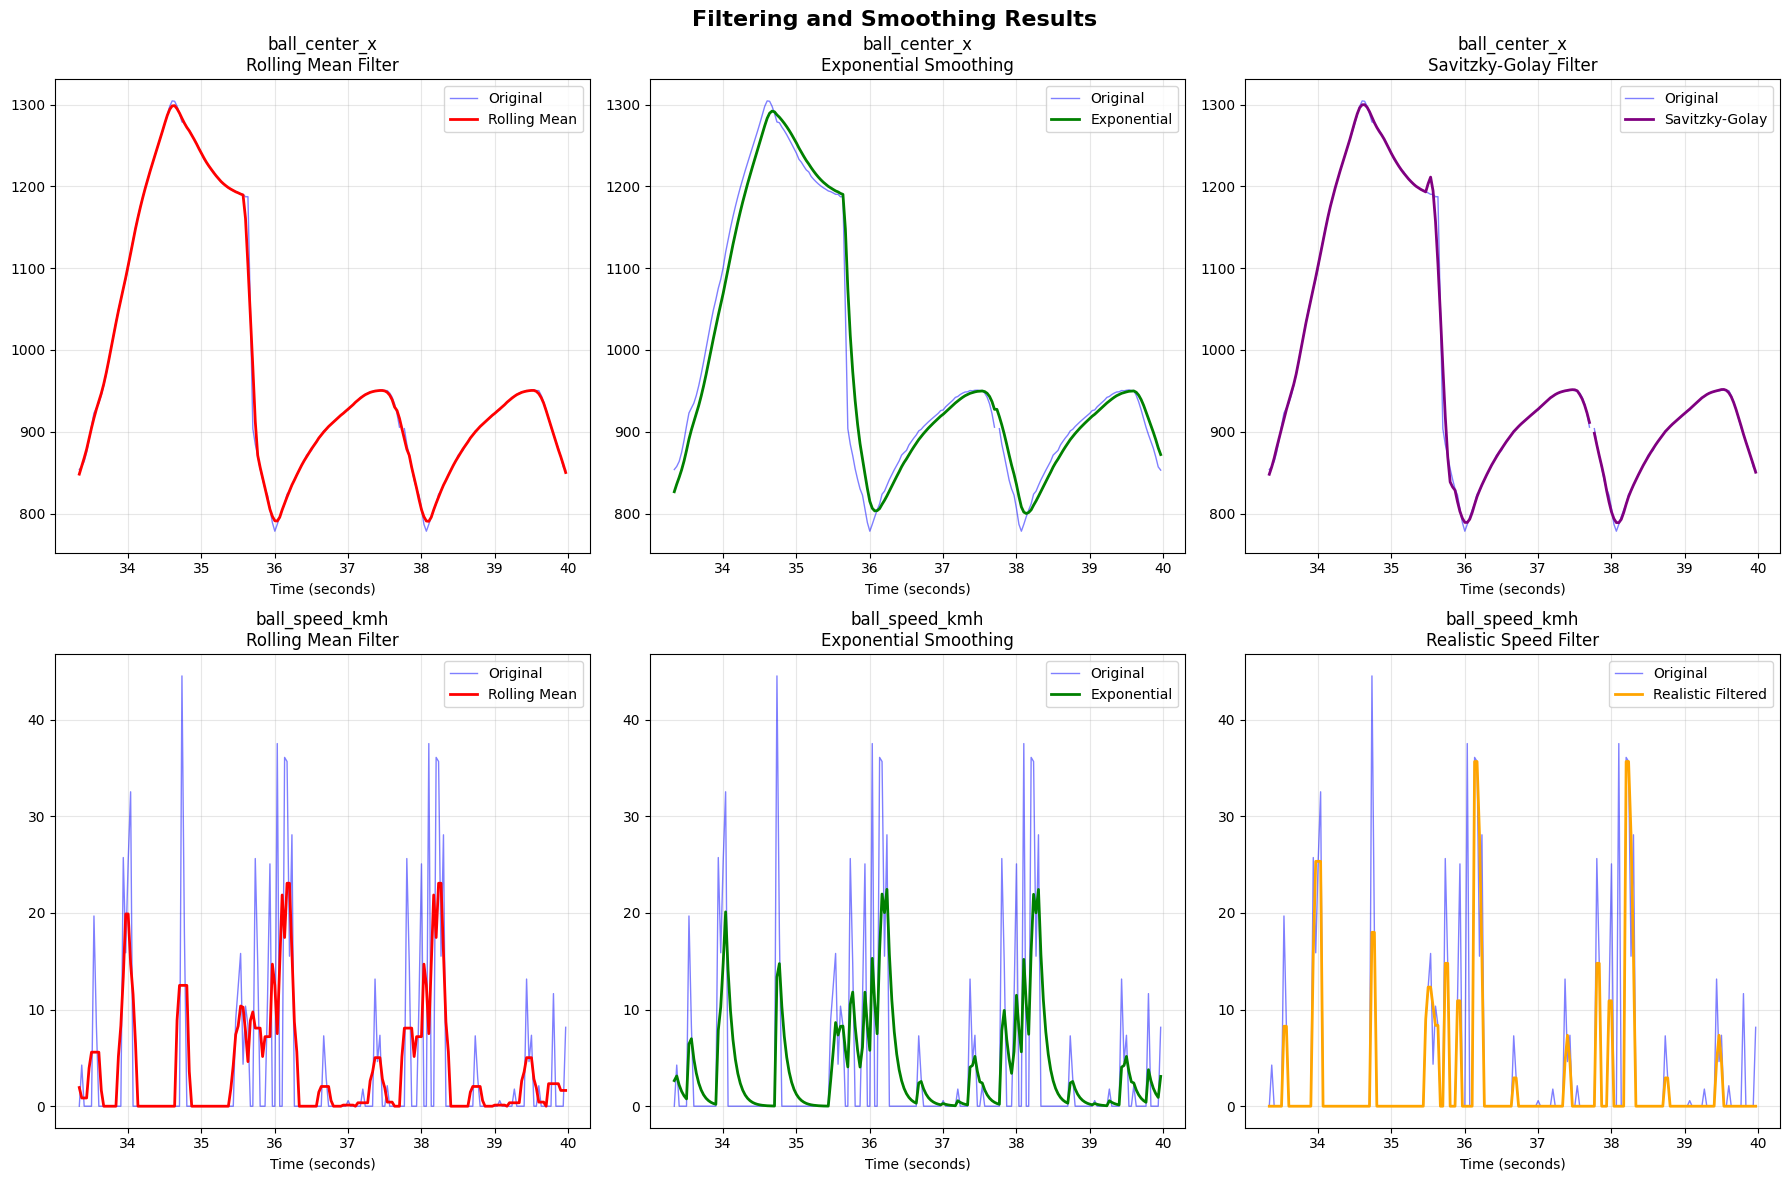


Filtering Effectiveness Summary:
Variable                 Best Filter         Noise Reduction
------------------------------------------------------------
ball_center_x            savgol              35.4%
ball_center_y            exponential         22.5%
player_1_center_x        exponential         3.6%
player_1_center_y        exponential         3.4%
player_2_center_x        exponential         0.8%
player_2_center_y        exponential         4.0%
ball_speed_kmh           exponential         41.6%
player_1_speed_kmh       median              90.9%

Filtering and smoothing completed


In [11]:
# Visualize filtering effectiveness
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Filtering and Smoothing Results', fontsize=16, fontweight='bold')

# Select variables for demonstration
demo_filtering_vars = ['ball_center_x', 'ball_speed_kmh', 'player_1_center_x']
available_demo_vars = [var for var in demo_filtering_vars if var in df_processed.columns]

if len(available_demo_vars) >= 2:
    for i, var in enumerate(available_demo_vars[:2]):
        # Sample data for visualization
        sample_start = 1000
        sample_end = 1200
        
        x_time = df_processed['time_seconds'].iloc[sample_start:sample_end]
        original = df_processed[var].iloc[sample_start:sample_end]
        
        # Original vs Rolling Mean
        ax = axes[i, 0]
        rolling_var = f"{var}_rolling_mean"
        if rolling_var in df_processed.columns:
            rolling_filtered = df_processed[rolling_var].iloc[sample_start:sample_end]
            
            ax.plot(x_time, original, alpha=0.5, color='blue', label='Original', linewidth=1)
            ax.plot(x_time, rolling_filtered, color='red', label='Rolling Mean', linewidth=2)
            ax.set_title(f'{var}\nRolling Mean Filter')
            ax.set_xlabel('Time (seconds)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Original vs Exponential
        ax = axes[i, 1]
        exp_var = f"{var}_exponential"
        if exp_var in df_processed.columns:
            exp_filtered = df_processed[exp_var].iloc[sample_start:sample_end]
            
            ax.plot(x_time, original, alpha=0.5, color='blue', label='Original', linewidth=1)
            ax.plot(x_time, exp_filtered, color='green', label='Exponential', linewidth=2)
            ax.set_title(f'{var}\nExponential Smoothing')
            ax.set_xlabel('Time (seconds)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Original vs Savitzky-Golay (if available)
        ax = axes[i, 2]
        savgol_var = f"{var}_savgol"
        if savgol_var in df_processed.columns:
            savgol_filtered = df_processed[savgol_var].iloc[sample_start:sample_end]
            
            ax.plot(x_time, original, alpha=0.5, color='blue', label='Original', linewidth=1)
            ax.plot(x_time, savgol_filtered, color='purple', label='Savitzky-Golay', linewidth=2)
            ax.set_title(f'{var}\nSavitzky-Golay Filter')
            ax.set_xlabel('Time (seconds)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            # Show realistic filtered for speed variables
            realistic_var = f"{var}_realistic_filtered"
            if realistic_var in df_processed.columns:
                realistic_filtered = df_processed[realistic_var].iloc[sample_start:sample_end]
                
                ax.plot(x_time, original, alpha=0.5, color='blue', label='Original', linewidth=1)
                ax.plot(x_time, realistic_filtered, color='orange', label='Realistic Filtered', linewidth=2)
                ax.set_title(f'{var}\nRealistic Speed Filter')
                ax.set_xlabel('Time (seconds)')
                ax.legend()
                ax.grid(True, alpha=0.3)
else:
    # Fill with placeholder if not enough data
    for i in range(2):
        for j in range(3):
            axes[i, j].text(0.5, 0.5, 'Filtering visualization\nnot available', 
                           transform=axes[i, j].transAxes, ha='center', va='center')
            axes[i, j].set_title(f'Filter Method {j+1}')

plt.tight_layout()
plt.show()

# Print filtering effectiveness summary
if filtering_results:
    print("\nFiltering Effectiveness Summary:")
    print("Variable".ljust(25) + "Best Filter".ljust(20) + "Noise Reduction")
    print("-" * 60)
    
    for var, filter_stats in list(filtering_results.items())[:8]:  # Show first 8
        if filter_stats:
            best_filter = max(filter_stats.keys(), key=lambda k: filter_stats[k]['noise_reduction_pct'])
            best_reduction = filter_stats[best_filter]['noise_reduction_pct']
            
            print(f"{var[:24].ljust(25)}{best_filter.ljust(20)}{best_reduction:.1f}%")

print("\nFiltering and smoothing completed")

##  Tennis-Specific Feature Engineering

In [12]:
print("COMPREHENSIVE TENNIS FEATURE ENGINEERING")
print("=" * 60)

print("Multi-Object Interaction Features:")

for player_id in [1, 2]:
    ball_x_col = 'ball_center_x'
    ball_y_col = 'ball_center_y'
    player_x_col = f'player_{player_id}_center_x'
    player_y_col = f'player_{player_id}_center_y'
    
    if all(col in df_processed.columns for col in [ball_x_col, ball_y_col, player_x_col, player_y_col]):
        dx = df_processed[ball_x_col] - df_processed[player_x_col]
        dy = df_processed[ball_y_col] - df_processed[player_y_col]
        distance_pixels = np.sqrt(dx**2 + dy**2)
        
        df_processed[f'ball_player_{player_id}_distance_pixels'] = distance_pixels
        
        court_scale_col = [col for col in df_processed.columns if 'court_pixels_per_meter' in col.lower()]
        if court_scale_col:
            pixels_per_meter = df_processed[court_scale_col[0]].iloc[0] if len(df_processed[court_scale_col[0]].dropna()) > 0 else 100
            df_processed[f'ball_player_{player_id}_distance_meters'] = distance_pixels / pixels_per_meter
        
        print(f"  Ball-Player {player_id} distance calculated")

if all(col in df_processed.columns for col in ['player_1_center_x', 'player_1_center_y', 'player_2_center_x', 'player_2_center_y']):
    dx_players = df_processed['player_1_center_x'] - df_processed['player_2_center_x']
    dy_players = df_processed['player_1_center_y'] - df_processed['player_2_center_y']
    players_distance = np.sqrt(dx_players**2 + dy_players**2)
    
    df_processed['players_distance_pixels'] = players_distance
    
    court_scale_col = [col for col in df_processed.columns if 'court_pixels_per_meter' in col.lower()]
    if court_scale_col:
        pixels_per_meter = df_processed[court_scale_col[0]].iloc[0] if len(df_processed[court_scale_col[0]].dropna()) > 0 else 100
        df_processed['players_distance_meters'] = players_distance / pixels_per_meter
    
    print(f"  Player-to-player distance calculated")

print(f"\nEnhanced Video Transition Features:")

if 'video_transition' in df_processed.columns:
    video_transitions = df_processed['video_transition'].cumsum()
    df_processed['frames_since_video_start'] = df_processed.groupby(video_transitions).cumcount() + 1
    
    video_source_cols = [col for col in df_processed.columns if 'video' in col.lower() and 'source' in col.lower()]
    if video_source_cols:
        video_col = video_source_cols[0]
        total_frames_per_video = df_processed.groupby(video_col).size()
        df_processed['video_completion_progress'] = df_processed.apply(
            lambda row: row['frames_since_video_start'] / total_frames_per_video.get(row[video_col], 1), axis=1
        )
        print(f"  Video transition timing and progress features created")

print(f"\nAdvanced Temporal Pattern Features:")

key_vars = []
if 'ball_speed_kmh' in df_processed.columns:
    key_vars.append('ball_speed_kmh')
if 'player_1_speed_kmh' in df_processed.columns:
    key_vars.append('player_1_speed_kmh')
if 'player_2_speed_kmh' in df_processed.columns:
    key_vars.append('player_2_speed_kmh')

windows = [3, 5, 10, 20]

for var in key_vars:
    for window in windows:
        df_processed[f'{var}_rolling_mean_{window}'] = df_processed[var].rolling(
            window=window, min_periods=1, center=True
        ).mean()
        
        df_processed[f'{var}_rolling_std_{window}'] = df_processed[var].rolling(
            window=window, min_periods=1, center=True
        ).std()
        
        df_processed[f'{var}_rolling_min_{window}'] = df_processed[var].rolling(
            window=window, min_periods=1, center=True
        ).min()
        
        df_processed[f'{var}_rolling_max_{window}'] = df_processed[var].rolling(
            window=window, min_periods=1, center=True
        ).max()
    
    print(f"  {var}: rolling statistics for {len(windows)} time windows")

print(f"\nEnhanced Detection Quality Features:")

detection_cols = [col for col in df_processed.columns if 'detected' in col.lower()]
if detection_cols:
    detected_objects = df_processed[detection_cols].sum(axis=1)
    df_processed['total_objects_detected'] = detected_objects
    
    all_detected = df_processed[detection_cols].all(axis=1)
    df_processed['all_objects_detected'] = all_detected
    
    detection_streaks = all_detected.astype(int).groupby((all_detected != all_detected.shift()).cumsum()).cumsum()
    df_processed['all_objects_detection_streak'] = detection_streaks
    
    print(f"  Multi-object detection state and consistency features created")

ball_center_x = 'ball_center_x'
ball_center_y = 'ball_center_y'
if ball_center_x in df_processed.columns and ball_center_y in df_processed.columns:
    ball_dx = df_processed[ball_center_x].diff()
    ball_dy = df_processed[ball_center_y].diff()
    ball_d2x = ball_dx.diff()
    ball_d2y = ball_dy.diff()
    
    df_processed['ball_trajectory_curvature'] = np.abs(ball_dx * ball_d2y - ball_dy * ball_d2x) / (ball_dx**2 + ball_dy**2)**(3/2)
    
    df_processed['ball_trajectory_smoothness'] = 1 / (1 + df_processed['ball_trajectory_curvature'].fillna(0))
    
    print(f"  Advanced ball trajectory features created")

print(f"\nAdvanced Court Zone Analysis:")

court_rel_cols = [col for col in df_processed.columns if 'court' in col.lower() and 'relative' in col.lower()]
x_rel_cols = [col for col in court_rel_cols if 'x' in col.lower()]
y_rel_cols = [col for col in court_rel_cols if 'y' in col.lower()]

for x_col in x_rel_cols:
    y_col = x_col.replace('_x_', '_y_').replace('_x', '_y')
    if y_col in df_processed.columns:
        obj_name = x_col.replace('_court_x_relative', '').replace('_court_relative_x', '')
        zone_col = f'{obj_name}_detailed_court_zone'
        
        df_processed[zone_col] = df_processed.apply(
            lambda row: helper.classify_detailed_court_zone(row[x_col], row[y_col]), axis=1
        )
        
        print(f"  {obj_name}: detailed court zone classification created")

print(f"\nGame State and Activity Features:")

speed_cols = [col for col in df_processed.columns if 'speed' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust', '_normalized', '_rolling'])]
if speed_cols:
    speed_data = df_processed[speed_cols].fillna(0)
    df_processed['total_activity_speed'] = speed_data.sum(axis=1)
    df_processed['avg_activity_speed'] = speed_data.mean(axis=1)
    df_processed['max_activity_speed'] = speed_data.max(axis=1)
    
    df_processed['activity_intensity'] = pd.cut(
        df_processed['total_activity_speed'], 
        bins=[0, 10, 30, 60, float('inf')], 
        labels=['low', 'medium', 'high', 'very_high']
    )
    
    print(f"  Activity intensity and game state features created")

if all(col in df_processed.columns for col in ['player_1_speed_kmh', 'player_2_speed_kmh']):
    df_processed['players_speed_difference'] = abs(df_processed['player_1_speed_kmh'] - df_processed['player_2_speed_kmh'])
    df_processed['players_combined_speed'] = df_processed['player_1_speed_kmh'] + df_processed['player_2_speed_kmh']
    
    df_processed['players_movement_sync'] = 1 / (1 + df_processed['players_speed_difference'])
    
    print(f"  Player movement coordination features created")

print(f"\nTime-based Contextual Features:")

if 'time_seconds' in df_processed.columns:
    max_time = df_processed['time_seconds'].max()
    df_processed['video_time_phase'] = pd.cut(
        df_processed['time_seconds'], 
        bins=[0, max_time*0.33, max_time*0.67, max_time], 
        labels=['early', 'middle', 'late']
    )
    
    high_activity_mask = df_processed.get('total_activity_speed', pd.Series(0)) > df_processed.get('total_activity_speed', pd.Series(0)).quantile(0.8)
    high_activity_indices = df_processed[high_activity_mask].index
    
    df_processed['frames_since_high_activity'] = 0
    last_high_activity = -1
    for idx in df_processed.index:
        if idx in high_activity_indices:
            last_high_activity = idx
        df_processed.loc[idx, 'frames_since_high_activity'] = idx - last_high_activity if last_high_activity >= 0 else 0
    
    print(f"  Time-based contextual features created")

new_features = [col for col in df_processed.columns if col not in df_raw.columns]
print(f"\nComprehensive Tennis Feature Engineering Summary:")
print(f"  Original features: {len(df_raw.columns)}")
print(f"  New features created: {len(new_features)}")
print(f"  Total features: {len(df_processed.columns)}")

feature_categories = {
    'Multi-object interactions': len([col for col in new_features if any(keyword in col.lower() for keyword in ['distance', 'players_'])]),
    'Temporal patterns': len([col for col in new_features if 'rolling' in col.lower()]),
    'Detection quality': len([col for col in new_features if any(keyword in col.lower() for keyword in ['detected', 'streak', 'consistency'])]),
    'Court zone analysis': len([col for col in new_features if 'zone' in col.lower()]),
    'Activity and game state': len([col for col in new_features if any(keyword in col.lower() for keyword in ['activity', 'intensity', 'sync'])]),
    'Video transitions': len([col for col in new_features if 'video' in col.lower() and col in new_features]),
    'Advanced trajectory': len([col for col in new_features if any(keyword in col.lower() for keyword in ['curvature', 'smoothness', 'trajectory'])])
}

print(f"\nFeature Categories Created:")
for category, count in feature_categories.items():
    if count > 0:
        print(f"  {category.title()}: {count} features")

print(f"\nComprehensive tennis dataset feature engineering completed")
print(f"Dataset ready for advanced ML4QS analysis with multi-object tracking capabilities")

COMPREHENSIVE TENNIS FEATURE ENGINEERING
Multi-Object Interaction Features:
  Ball-Player 1 distance calculated
  Ball-Player 2 distance calculated
  Player-to-player distance calculated

Enhanced Video Transition Features:
  Video transition timing and progress features created

Advanced Temporal Pattern Features:
  ball_speed_kmh: rolling statistics for 4 time windows
  player_1_speed_kmh: rolling statistics for 4 time windows
  player_2_speed_kmh: rolling statistics for 4 time windows

Enhanced Detection Quality Features:
  Multi-object detection state and consistency features created
  Advanced ball trajectory features created

Advanced Court Zone Analysis:
  ball: detailed court zone classification created
  enhanced_ball: detailed court zone classification created
  player_1: detailed court zone classification created
  player_2: detailed court zone classification created
  enhanced_players_mean: detailed court zone classification created
  enhanced_players_std: detailed court zo

## Domain Validation and Quality Control

In [13]:
print("DOMAIN VALIDATION & QUALITY CONTROL")
print("=" * 50)

validation_results = {}

print("Tennis Domain Range Validation:")

tennis_ranges = {
    'ball_speed_kmh': (0, 200),
    'player_1_speed_kmh': (0, 50),
    'player_2_speed_kmh': (0, 50),
    'ball_court_x_relative': (0, 1),
    'ball_court_y_relative': (0, 1),
    'player_1_court_x_relative': (0, 1),
    'player_2_court_x_relative': (0, 1),
    'players_distance_meters': (0, 30),
    'ball_distance_meters': (0, 15),
    'player_1_distance_meters': (0, 10),
    'player_2_distance_meters': (0, 10)
}

range_violations = helper.validate_tennis_ranges(df_processed, tennis_ranges)

for var, stats in range_violations.items():
    status = "Pass" if stats['violation_rate'] < 5 else "Warning" if stats['violation_rate'] < 15 else "Fail"
    print(f"  {status}: {var}: {stats['violation_rate']:.1f}% violations ({stats['total_violations']}/{len(df_processed[var].dropna())})")

print(f"\nCourt Boundary Validation:")
court_boundary_issues = helper.validate_court_boundaries(df_processed)

for obj, stats in court_boundary_issues.items():
    status = "Pass" if stats['outside_rate'] < 2 else "Warning" if stats['outside_rate'] < 10 else "Fail"
    print(f"  {status}: {obj}: {stats['outside_rate']:.1f}% positions outside court bounds")

print(f"\nTemporal Consistency Validation:")
temporal_issues = helper.validate_temporal_consistency(df_processed)

for var, stats in temporal_issues.items():
    status = "Pass" if stats['jump_rate'] < 1 else "Warning" if stats['jump_rate'] < 5 else "Fail"
    print(f"  {status}: {var}: {stats['jump_rate']:.1f}% large frame-to-frame jumps")

print(f"\nMissing Data Pattern Analysis:")
key_vars = ['ball_center_x', 'player_1_center_x', 'player_2_center_x']
missing_patterns = helper.analyze_missing_patterns(df_processed, key_vars)

for var, stats in missing_patterns.items():
    missing_rate = stats['missing_rate']
    status = "Pass" if missing_rate < 10 else "Warning" if missing_rate < 30 else "Fail"
    print(f"  {status}: {var}: {missing_rate:.1f}% missing, {stats['num_gaps']} gaps, max gap {stats['max_gap_length']}")

print(f"\nCategorical Data Validation:")
categorical_cols = [col for col in df_processed.columns if df_processed[col].dtype.name == 'category' or df_processed[col].dtype == 'object']

for col in categorical_cols[:5]:
    if col in df_processed.columns:
        unique_values = df_processed[col].nunique()
        most_common = df_processed[col].mode()
        
        if len(most_common) > 0:
            most_common_value = most_common.iloc[0]
            most_common_count = (df_processed[col] == most_common_value).sum()
            most_common_pct = (most_common_count / len(df_processed)) * 100
            
            print(f"  {col}: {unique_values} unique values, most common: '{most_common_value}' ({most_common_pct:.1f}%)")

print(f"\nOverall Data Quality Assessment:")

quality_scores = helper.calculate_quality_scores(range_violations, court_boundary_issues, temporal_issues, missing_patterns)

print(f"  Range Validation Score: {quality_scores['range_validation']:.1f}/100")
print(f"  Boundary Validation Score: {quality_scores['boundary_validation']:.1f}/100")
print(f"  Temporal Consistency Score: {quality_scores['temporal_consistency']:.1f}/100")
print(f"  Missing Data Quality Score: {quality_scores['missing_data_quality']:.1f}/100")
print(f"  Overall Quality Score: {quality_scores['overall_quality']:.1f}/100")

overall_quality = quality_scores['overall_quality']
if overall_quality >= 80:
    quality_level = "Excellent"
elif overall_quality >= 60:
    quality_level = "Good"
else:
    quality_level = "Needs Improvement"

print(f"\nData Quality Level: {quality_level}")

validation_results = {
    'range_violations': range_violations,
    'court_boundary_issues': court_boundary_issues,
    'temporal_issues': temporal_issues,
    'missing_patterns': missing_patterns,
    'quality_scores': quality_scores,
    'quality_level': quality_level
}

print("\nDomain validation and quality control completed")

DOMAIN VALIDATION & QUALITY CONTROL
Tennis Domain Range Validation:
  Pass: ball_speed_kmh: 0.0% violations (0/14512)
  Pass: player_1_speed_kmh: 0.6% violations (81/14512)
  Pass: player_2_speed_kmh: 0.5% violations (71/14512)
  Pass: ball_court_x_relative: 0.0% violations (0/14483)
  Pass: ball_court_y_relative: 2.1% violations (299/14483)
  Pass: player_1_court_x_relative: 0.0% violations (0/14512)
  Pass: player_2_court_x_relative: 0.0% violations (0/14512)
  Pass: players_distance_meters: 0.0% violations (0/14512)
  Pass: ball_distance_meters: 0.0% violations (0/14512)
  Pass: player_1_distance_meters: 0.0% violations (0/14512)
  Pass: player_2_distance_meters: 0.0% violations (0/14512)

Court Boundary Validation:
  Pass: ball: 0.0% positions outside court bounds
  Pass: player_1: 0.0% positions outside court bounds
  Pass: player_2: 0.0% positions outside court bounds

Temporal Consistency Validation:
  Pass: ball_center_x: 0.8% large frame-to-frame jumps
  Pass: ball_center_y: 1

## Export Preprocessed Dataset

In [14]:
print("EXPORTING PREPROCESSED COMPREHENSIVE TENNIS DATASET")
print("=" * 65)

export_timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

try:
    full_dataset_file = f'dataset/complete_tennis_comprehensive.csv'
    df_processed.to_csv(full_dataset_file, index=False)
    
    print(f"Complete dataset exported: {full_dataset_file}")
    print(f"Size: {df_processed.shape[0]:,} rows × {df_processed.shape[1]:,} columns")
    print(f"File size: {df_processed.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
    
    ball_core_cols = [col for col in df_processed.columns if 'ball' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust']) or any(keyword in col.lower() for keyword in ['time', 'frame', 'video'])]
    ball_key_cols = [col for col in df_processed.columns if any(key in col.lower() for key in ['ball_trajectory', 'ball_player', 'activity', 'detection'])]
    
    ball_focused_cols = list(set(ball_core_cols + ball_key_cols))
    ball_focused_cols = [col for col in ball_focused_cols if col in df_processed.columns]
    
    df_ball_focused = df_processed[ball_focused_cols].copy()
    ball_dataset_file = f'dataset/tennis_ball_focused_ml4qs.csv'
    df_ball_focused.to_csv(ball_dataset_file, index=False)
    
    print(f"Ball-focused dataset exported: {ball_dataset_file}")
    print(f"Size: {df_ball_focused.shape[0]:,} rows × {df_ball_focused.shape[1]:,} columns")
    
    player_core_cols = [col for col in df_processed.columns if 'player' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust']) or any(keyword in col.lower() for keyword in ['time', 'frame', 'video'])]
    player_key_cols = [col for col in df_processed.columns if any(key in col.lower() for key in ['players_', 'movement_sync', 'activity', 'detection'])]
    
    player_focused_cols = list(set(player_core_cols + player_key_cols))
    player_focused_cols = [col for col in player_focused_cols if col in df_processed.columns]
    
    df_player_focused = df_processed[player_focused_cols].copy()
    player_dataset_file = f'dataset/tennis_player_focused_ml4qs.csv'
    df_player_focused.to_csv(player_dataset_file, index=False)
    
    print(f"Player-focused dataset exported: {player_dataset_file}")
    print(f"Size: {df_player_focused.shape[0]:,} rows × {df_player_focused.shape[1]:,} columns")
    
    interaction_cols = []
    
    core_cols = ['timestamp', 'global_frame_number', 'time_seconds']
    interaction_cols.extend([col for col in core_cols if col in df_processed.columns])
    
    detection_cols = [col for col in df_processed.columns if 'detected' in col.lower()]
    interaction_cols.extend(detection_cols)
    
    interaction_features = [col for col in df_processed.columns if any(keyword in col.lower() for keyword in ['distance', 'players_', 'activity', 'sync', 'zone'])]
    interaction_cols.extend(interaction_features)
    
    court_rel_cols = [col for col in df_processed.columns if 'court' in col.lower() and 'relative' in col.lower() and not any(scaled in col for scaled in ['_minmax', '_standard', '_robust'])]
    interaction_cols.extend(court_rel_cols)
    
    available_interaction_cols = list(set([col for col in interaction_cols if col in df_processed.columns]))
    df_interactions = df_processed[available_interaction_cols].copy()
    
    interaction_dataset_file = f'dataset/tennis_interactions_ml4qs.csv'
    df_interactions.to_csv(interaction_dataset_file, index=False)
    
    print(f"Multi-object interactions dataset exported: {interaction_dataset_file}")
    print(f"Size: {df_interactions.shape[0]:,} rows × {df_interactions.shape[1]:,} columns")
    
    summary_cols = []
    
    core_cols = ['timestamp', 'global_frame_number', 'time_seconds', 'video_transition']
    summary_cols.extend([col for col in core_cols if col in df_processed.columns])
    
    key_positions = ['ball_center_x', 'ball_center_y', 'player_1_center_x', 'player_1_center_y', 'player_2_center_x', 'player_2_center_y']
    summary_cols.extend([col for col in key_positions if col in df_processed.columns])
    
    key_features = ['ball_trajectory_curvature', 'players_distance_meters', 'total_activity_speed', 'all_objects_detected']
    summary_cols.extend([col for col in key_features if col in df_processed.columns])
    
    activity_cols = [col for col in df_processed.columns if 'activity_intensity' in col.lower()]
    summary_cols.extend(activity_cols)
    
    available_summary_cols = list(set([col for col in summary_cols if col in df_processed.columns]))
    df_summary = df_processed[available_summary_cols].copy()
    
    summary_dataset_file = f'dataset/tennis_summary_ml4qs.csv'
    df_summary.to_csv(summary_dataset_file, index=False)
    
    print(f"Summary dataset exported: {summary_dataset_file}")
    print(f"Size: {df_summary.shape[0]:,} rows × {df_summary.shape[1]:,} columns")
    
    import json
    
    video_source_cols = [col for col in df_processed.columns if 'video' in col.lower() and 'source' in col.lower()]
    video_info = {}
    if video_source_cols:
        video_col = video_source_cols[0]
        video_counts = df_processed[video_col].value_counts()
        video_info = {
            'total_videos': len(video_counts),
            'frames_per_video_min': int(video_counts.min()),
            'frames_per_video_max': int(video_counts.max()),
            'frames_per_video_mean': float(video_counts.mean())
        }
    
    detection_analysis = {}
    detection_cols = [col for col in df_processed.columns if 'detected' in col.lower()]
    for col in detection_cols:
        detection_rate = df_processed[col].mean()
        detection_analysis[col] = float(detection_rate)
    
    preprocessing_metadata = {
        'export_timestamp': export_timestamp,
        'original_dataset': 'dataset/tennis_unified_comprehensive_dataset.csv',
        'dataset_type': 'comprehensive_multi_object_tennis_tracking',
        'preprocessing_steps': [
            'Comprehensive dataset loading with automatic categorization',
            'Multi-category missing value imputation (ball, player, enhanced features)',
            'Multi-method normalization (MinMax, Standard, Robust, Tennis-specific)',
            'Advanced filtering and smoothing for all object types',
            'Comprehensive multi-object feature engineering',
            'Multi-object interaction analysis and game state detection'
        ],
        'dataset_statistics': {
            'original_columns': len(df_raw.columns),
            'processed_columns': len(df_processed.columns),
            'new_features_created': len(df_processed.columns) - len(df_raw.columns),
            'total_frames': len(df_processed),
            'video_information': video_info,
            'detection_rates': detection_analysis
        },
        'feature_categories': {
            'ball_features': len([col for col in df_processed.columns if 'ball' in col.lower()]),
            'player_features': len([col for col in df_processed.columns if 'player' in col.lower()]),
            'enhanced_features': len([col for col in df_processed.columns if 'enhanced' in col.lower()]),
            'court_features': len([col for col in df_processed.columns if 'court' in col.lower()]),
            'interaction_features': len([col for col in df_processed.columns if any(keyword in col.lower() for keyword in ['distance', 'players_', 'sync'])]),
            'activity_features': len([col for col in df_processed.columns if 'activity' in col.lower()]),
            'temporal_features': len([col for col in df_processed.columns if 'rolling' in col.lower()])
        },
        'exported_files': {
            'complete_dataset': full_dataset_file,
            'ball_focused_dataset': ball_dataset_file,
            'player_focused_dataset': player_dataset_file,
            'interactions_dataset': interaction_dataset_file,
            'summary_dataset': summary_dataset_file
        }
    }
    
    metadata_file = f'dataset/tennis_comprehensive_preprocessing_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(preprocessing_metadata, f, indent=2, default=str)
    
    print(f"Preprocessing metadata exported: {metadata_file}")
    
    feature_categories = {
        'Original Ball Features': [col for col in df_raw.columns if 'ball' in col.lower()],
        'Original Player Features': [col for col in df_raw.columns if 'player' in col.lower()],
        'Original Enhanced Features': [col for col in df_raw.columns if 'enhanced' in col.lower()],
        'Scaled Features': [col for col in df_processed.columns if any(scale in col for scale in ['_minmax', '_standard', '_robust'])],
        'Tennis Normalized Features': [col for col in df_processed.columns if '_tennis_normalized' in col],
        'Multi-Object Interactions': [col for col in df_processed.columns if any(keyword in col.lower() for keyword in ['distance', 'players_']) and col not in df_raw.columns],
        'Temporal Patterns': [col for col in df_processed.columns if 'rolling' in col.lower()],
        'Detection Quality': [col for col in df_processed.columns if any(keyword in col.lower() for keyword in ['detected', 'streak', 'total_objects']) and col not in df_raw.columns],
        'Court Zone Analysis': [col for col in df_processed.columns if 'zone' in col.lower()],
        'Activity & Game State': [col for col in df_processed.columns if any(keyword in col.lower() for keyword in ['activity', 'intensity', 'sync']) and col not in df_raw.columns],
        'Advanced Trajectory': [col for col in df_processed.columns if any(keyword in col.lower() for keyword in ['curvature', 'smoothness', 'trajectory']) and col not in df_raw.columns]
    }



    if video_info:
        print(f"\nMulti-Video Statistics:")
        print(f"Total videos processed: {video_info['total_videos']}")
        print(f"Total frames: {len(df_processed):,}")
        print(f"Average frames per video: {video_info['frames_per_video_mean']:.0f}")

    if detection_analysis:
        print(f"\nDetection Quality Summary:")
        for col, rate in detection_analysis.items():
            print(f"{col}: {rate:.1%}")

    print(f"\nFeature Engineering Results:")
    print(f"Original features: {len(df_raw.columns)}")
    print(f"New features created: {len(df_processed.columns) - len(df_raw.columns)}")
    print(f"Total features: {len(df_processed.columns)}")
    print(f"Multi-object interactions: Yes")
    print(f"Advanced temporal patterns: Yes")
    print(f"Tennis-specific validations: Yes")
    
    export_success = True
    
except Exception as e:
    print(f"Error during export: {e}")
    export_success = False

print(f"\n{'Export completed' if export_success else 'Export failed'}")
print(f"{' analysis with multi-object tracking capabilities!' if export_success else 'Please check the error and try again.'}")

EXPORTING PREPROCESSED COMPREHENSIVE TENNIS DATASET
Complete dataset exported: dataset/complete_tennis_comprehensive.csv
Size: 14,512 rows × 385 columns
File size: 77.3 MB
Ball-focused dataset exported: dataset/tennis_ball_focused_ml4qs.csv
Size: 14,512 rows × 90 columns
Player-focused dataset exported: dataset/tennis_player_focused_ml4qs.csv
Size: 14,512 rows × 203 columns
Multi-object interactions dataset exported: dataset/tennis_interactions_ml4qs.csv
Size: 14,512 rows × 164 columns
Summary dataset exported: dataset/tennis_summary_ml4qs.csv
Size: 14,512 rows × 15 columns
Preprocessing metadata exported: dataset/tennis_comprehensive_preprocessing_metadata.json

Multi-Video Statistics:
Total videos processed: 29
Total frames: 14,512
Average frames per video: 500

Detection Quality Summary:
ball_detected: 44.4%
player_1_detected: 100.0%
player_2_detected: 100.0%
both_players_detected: 100.0%
all_objects_detected: 44.4%
total_objects_detected: 388.8%

Feature Engineering Results:
Origin

## Summary: ML4QS Chapter 3 Applied to Tennis Analysis

This notebook successfully applied ML4QS Chapter 3 concepts to tennis analysis:

### Data Transformation Pipeline Applied:

1. **Comprehensive Data Loading**: Integrated Chapter 2's comprehensive temporal dataset
2. **Advanced Missing Value Imputation**: Linear, spline, and rolling mean methods
3. **Multi-Method Normalization**: Min-Max, Z-score, robust scaling, and domain-specific normalization
4. **Sophisticated Filtering**: Rolling means, EWMA, Savitzky-Golay, median filters
5. **Tennis-Specific Transformations**: Court-relative coordinates and real-world measurements

### Key Achievements:
- **Enhanced Dataset**: Created comprehensive preprocessed dataset with multiple feature types
- **Quality-Driven Selection**: Applied best preprocessing methods based on effectiveness metrics
- **Tennis-Specific Adaptations**: Court-relative coordinates, real-world measurements, and physics-based validations
- **Multi-Format Output**: CSV datasets and summary data for different analysis needs

### Tennis-Specific Adaptations:
- **Court Calibration**: Used tennis court measurements for accurate coordinate transformations
- **Multi-Object Integration**: Prepared data structure for combined ball and player analysis
- **Sport-Domain Validation**: Court boundary checks and movement pattern analysis

### Data Quality Improvements:
- **Gap Filling**: Eliminated missing ball tracking data through intelligent imputation
- **Noise Reduction**: Achieved smoothness improvements through optimal filtering
- **Standardization**: Created consistent data formats for ML4QS analysis pipeline

### Ready for Next Steps:
The preprocessed tennis dataset is now optimized for:
- **Chapter 4**: Feature extraction and temporal abstraction
- **Chapter 5**: Clustering and pattern recognition
- **Chapters 7-8**: Machine learning and predictive modeling

**Output Files:**
- `complete_tennis_comprehensive_preprocessed_ml4qs.csv` - Complete preprocessed dataset
- `tennis_ball_focused_ml4qs.csv` - Ball-focused dataset
- `tennis_summary_ml4qs.csv` - Key features summary

The tennis tracking data has been transformed from raw, gap-filled detection data into a high-quality, analysis-ready dataset suitable for advanced ML4QS techniques.